# Connect adult lupus misclassifications to disease activity or treatment

Hypothesis: adult lupus patient misclassifications as healthy (instead of correct prediction as lupus) correlates with lower clinical disease activity scores (SLEDAI). This cohort of patients is on treatment.

Process:
- 3 types of patient datasets corresponding to 3 types of blood samples: PBMC, RNA, Paxgene
- PBMC dataset has all the info needed (`specimen_label` is already set, so merging in SLEDAI scores is easy)
- RNA dataset is missing `specimen_label`. We need to set that by merging on `EXS_ID=specimen_alternative_label`
- Paxgene dataset update is missing `specimen_label`. We will merge on `BSID` metadata column.
- Combine the PBMC, RNA, and Paxgene datasets now with specimen labels
- Compare healthy/lupus predicted label versus SLEDAI score

We do this for BCR only, because that's where the bulk of our adult lupus cohort (the one with SLEDAI scores available) is.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

%matplotlib inline
import seaborn as sns
from statannotations.Annotator import Annotator
import scipy.stats as stats
import genetools


from malid import config
import crosseval
from malid.datamodels import (
    TargetObsColumnEnum,
    GeneLocus,
    healthy_label,
)
from malid.trained_model_wrappers import BlendingMetamodel

In [2]:
sns.set()

## Load data

In [3]:
pd.set_option("display.max_columns", None)

In [4]:
# load SLEDAI scores. only some rows have been matched to our specimen_labels already. we'll have to match the rest by other metadata columns here.
# note that sledai's can be NaN or negative; both are invalid values
sledai_score_df = pd.read_csv(config.paths.metadata_dir / "sledai_scores.csv")
sledai_score_df

,SampleType,BSID,EXS_ID,specimen_label,SLEDAI_TotalScore,SLEDAI_20_LowComplement,SLEDAI_21_DNAbinding
0,RNA,NaN,AA02943,NaN,4.0,NaN,1.0
1,RNA,NaN,AA03233,NaN,-1.0,NaN,1.0
2,RNA,NaN,AA03206,NaN,4.0,1.0,NaN
3,RNA,NaN,AA03317,NaN,NaN,NaN,NaN
4,RNA,NaN,AA03449,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
133,RNA,NaN,AA05110,NaN,NaN,NaN,NaN
134,Paxgene,BS965589,NaN,NaN,2.0,NaN,NaN
135,Paxgene,BS766431,NaN,NaN,NaN,NaN,NaN
136,RNA,NaN,AA02830,NaN,NaN,NaN,NaN


In [5]:
sledai_score_df["SampleType"].value_counts()

PBMC       68
RNA        59
Paxgene    11
Name: SampleType, dtype: int64

In [6]:
sledai_score_df["SampleType"].isna().value_counts()

False    138
Name: SampleType, dtype: int64

In [7]:
sledai_score_df[sledai_score_df["SLEDAI_TotalScore"].notnull()][
    "SampleType"
].value_counts()

RNA        37
PBMC       32
Paxgene     3
Name: SampleType, dtype: int64

In [8]:
sledai_score_df.shape

(138, 7)

In [9]:
# Let's go ahead and filter out invalid values: nulls and negatives
sledai_score_df = sledai_score_df[
    (sledai_score_df["SLEDAI_TotalScore"].notnull())
    & (sledai_score_df["SLEDAI_TotalScore"] >= 0)
].copy()
sledai_score_df.shape

(65, 7)

In [10]:
# now that we don't have NaNs, we can cast to int
sledai_score_df["SLEDAI_TotalScore"] = sledai_score_df["SLEDAI_TotalScore"].astype(int)

In [11]:
# We can also now fill-na on the SLEDAI component columns:
for col in ["SLEDAI_20_LowComplement", "SLEDAI_21_DNAbinding"]:
    sledai_score_df[col] = sledai_score_df[col].fillna(0).astype(int)
sledai_score_df

,SampleType,BSID,EXS_ID,specimen_label,SLEDAI_TotalScore,SLEDAI_20_LowComplement,SLEDAI_21_DNAbinding
0,RNA,NaN,AA02943,NaN,4,0,1
2,RNA,NaN,AA03206,NaN,4,1,0
8,RNA,NaN,AA03620,NaN,4,0,1
9,RNA,NaN,AA03289,NaN,4,0,0
10,RNA,NaN,AA02013,NaN,2,0,1
...,...,...,...,...,...,...,...
103,PBMC,NaN,NaN,M281redo-S013,0,0,0
107,PBMC,NaN,NaN,M281redo-S005,4,0,0
111,PBMC,NaN,NaN,M281redo-S004,10,0,1
114,RNA,NaN,AA02596,NaN,11,1,1


In [12]:
# Compute SLEDAI clinical score by subtracting those two component columns, which each have score contribution value 2
sledai_score_df["SLEDAI_ClinicalScore"] = (
    sledai_score_df["SLEDAI_TotalScore"]
    - sledai_score_df["SLEDAI_20_LowComplement"]
    - sledai_score_df["SLEDAI_21_DNAbinding"]
)
sledai_score_df["SLEDAI_ClinicalScore"].describe()

count    65.000000
mean      3.584615
std       3.609416
min       0.000000
25%       0.000000
50%       3.000000
75%       6.000000
max      16.000000
Name: SLEDAI_ClinicalScore, dtype: float64

In [13]:
# sanity checks:
assert all(sledai_score_df["SLEDAI_ClinicalScore"] >= 0)
assert all(
    sledai_score_df["SLEDAI_ClinicalScore"] <= sledai_score_df["SLEDAI_TotalScore"]
)

In [14]:
# PBMC: already matched to specimen_labels
assert sledai_score_df[
    (sledai_score_df.SampleType == "PBMC")
    & (sledai_score_df["specimen_label"].isnull())
].empty
sledai_score_df[sledai_score_df.SampleType == "PBMC"].head(3)

,SampleType,BSID,EXS_ID,specimen_label,SLEDAI_TotalScore,SLEDAI_20_LowComplement,SLEDAI_21_DNAbinding,SLEDAI_ClinicalScore
45,PBMC,NaN,NaN,M281redo-S021,0,0,0,0
46,PBMC,NaN,NaN,M281redo-S015,2,0,1,1
47,PBMC,NaN,NaN,M281redo-S016,2,0,1,1


In [15]:
sample_type_pbmc_df = sledai_score_df[sledai_score_df.SampleType == "PBMC"]
sample_type_pbmc_df.shape

(32, 8)

In [16]:
# RNA: not matched to specimen_label. We need to join by EXS_ID.
sample_type_rna_df = sledai_score_df[sledai_score_df.SampleType == "RNA"]
sample_type_rna_df.head(3)

,SampleType,BSID,EXS_ID,specimen_label,SLEDAI_TotalScore,SLEDAI_20_LowComplement,SLEDAI_21_DNAbinding,SLEDAI_ClinicalScore
0,RNA,NaN,AA02943,NaN,4,0,1,3
2,RNA,NaN,AA03206,NaN,4,1,0,3
8,RNA,NaN,AA03620,NaN,4,0,1,3


In [17]:
# read adultlupus rna file. merge on specimen_alternative_label
adult_lupus_rna_df_raw = pd.read_csv(
    config.paths.metadata_dir / "adult_lupus_rna_M454_M455.specimens.tsv",
    sep="\t",
)
adult_lupus_rna_df_raw.head()

,participant_label,participant_alternative_label,disease,age,sex,ethnicity,participant_description,specimen_label,specimen_alternative_label,specimen_description
0,BFI-0010000,NaN,MS,53,F,Caucasian,RRMS Patient,M454-S001,AA02038,Age 53
1,BFI-0010001,NaN,MS,38,F,Caucasian,MS Patient,M454-S002,AA02040,Age 38
2,BFI-0010002,NaN,RA,34,F,Caucasian,RA Patient,M454-S003,AA02914,Age 34
3,BFI-0010003,NaN,SLE,58,F,Caucasian,SLE Patient,M454-S004,AA03435,Age 58
4,BFI-0010004,NaN,SLE,56,F,Caucasian,SLE Patient,M454-S005,AA03449,Age 56


In [18]:
# there are duplicate values for specimen_alternative_label' == 'AA01458'
adult_lupus_rna_df_raw["specimen_alternative_label"].value_counts()[
    adult_lupus_rna_df_raw["specimen_alternative_label"].value_counts() > 1
]

AA01458    2
Name: specimen_alternative_label, dtype: int64

In [19]:
# there are duplicate values for specimen_alternative_label' == 'AA01458'. Let's keep the first value by default
adult_lupus_rna_df_raw.loc[
    adult_lupus_rna_df_raw["specimen_alternative_label"] == "AA01458"
]

,participant_label,participant_alternative_label,disease,age,sex,ethnicity,participant_description,specimen_label,specimen_alternative_label,specimen_description
38,BFI-0010034,NaN,SLE,64,F,Caucasian,SLE Patient,M454-S040,AA01458,Age 64
39,BFI-0010034,NaN,SLE,64,F,Caucasian,SLE Patient,M454-S047,AA01458,Age 64


In [20]:
adult_lupus_rna_df_raw.shape

(60, 10)

In [21]:
# keep the first value of specimen_alternative_label
adult_lupus_rna_df = (
    adult_lupus_rna_df_raw.groupby("specimen_alternative_label").first().reset_index()
)
assert all(adult_lupus_rna_df["specimen_alternative_label"].value_counts() == 1)
print(adult_lupus_rna_df.shape)
adult_lupus_rna_df.head(2)

(59, 10)


,specimen_alternative_label,participant_label,participant_alternative_label,disease,age,sex,ethnicity,participant_description,specimen_label,specimen_description
0,AA00081,BFI-0010045,NaN,RA,31,F,Caucasian,RA Patient,M454-S053,Age 31
1,AA00151,BFI-0010042,NaN,SLE,42,F,Native American,SLE Patient,M454-S049,Age 42


In [22]:
sample_type_rna_df.head()

,SampleType,BSID,EXS_ID,specimen_label,SLEDAI_TotalScore,SLEDAI_20_LowComplement,SLEDAI_21_DNAbinding,SLEDAI_ClinicalScore
0,RNA,NaN,AA02943,NaN,4,0,1,3
2,RNA,NaN,AA03206,NaN,4,1,0,3
8,RNA,NaN,AA03620,NaN,4,0,1,3
9,RNA,NaN,AA03289,NaN,4,0,0,4
10,RNA,NaN,AA02013,NaN,2,0,1,1


In [23]:
# merge to get missing specimen_label for sample_type_rna_df dataset
sample_type_rna_df_merged = pd.merge(
    sample_type_rna_df.drop(columns="specimen_label"),
    adult_lupus_rna_df[["specimen_label", "specimen_alternative_label"]],
    left_on="EXS_ID",
    right_on="specimen_alternative_label",
    how="left",
    validate="1:1",
).drop(columns="specimen_alternative_label")

sample_type_rna_df_merged.head(2)

,SampleType,BSID,EXS_ID,SLEDAI_TotalScore,SLEDAI_20_LowComplement,SLEDAI_21_DNAbinding,SLEDAI_ClinicalScore,specimen_label
0,RNA,NaN,AA02943,4,0,1,3,M454-S023
1,RNA,NaN,AA03206,4,1,0,3,M454-S010


In [24]:
print(sample_type_rna_df.shape)
print(sample_type_rna_df_merged.shape)

(31, 8)
(31, 8)


In [25]:
# Paxgene: no specimen_labels merged yet. Will merge on BSID.
sample_type_paxgene_df = sledai_score_df[sledai_score_df.SampleType == "Paxgene"]
sample_type_paxgene_df.head()

,SampleType,BSID,EXS_ID,specimen_label,SLEDAI_TotalScore,SLEDAI_20_LowComplement,SLEDAI_21_DNAbinding,SLEDAI_ClinicalScore
44,Paxgene,BS767818,NaN,NaN,8,1,1,6
134,Paxgene,BS965589,NaN,NaN,2,0,0,2


In [26]:
# read adult lupus paxgene file
adult_lupus_paxgene_df = pd.read_csv(
    config.paths.metadata_dir / "adult_lupus_paxgene_M456_M457.specimens.tsv",
    sep="\t",
)
adult_lupus_paxgene_df.head()

,participant_label,disease,age,sex,ethnicity,participant_description,specimen_label,BSID
0,BFI-0010060,SLE,51,F,Caucasian,SLE Patient,M456-S001,BS1090567
1,BFI-0010061,SLE,34,F,African American,SLE Patient,M456-S002,BS1090648
2,BFI-0010062,MS,37,F,Caucasian,MS Patient,M456-S003,BS737900
3,BFI-0010063,MS,45,F,Caucasian,RRMS Patient,M456-S004,BS758986
4,BFI-0010064,Healthy/Background,48,M,Caucasian,Unaffected Control,M456-S005,BS766431


In [27]:
assert not sample_type_paxgene_df["BSID"].duplicated().any()

In [28]:
assert not adult_lupus_paxgene_df["BSID"].duplicated().any()

In [29]:
sample_type_paxgene_df_merged = pd.merge(
    sample_type_paxgene_df.drop(columns="specimen_label"),
    adult_lupus_paxgene_df,
    on="BSID",
    how="left",
    validate="1:1",
)
sample_type_paxgene_df_merged

,SampleType,BSID,EXS_ID,SLEDAI_TotalScore,SLEDAI_20_LowComplement,SLEDAI_21_DNAbinding,SLEDAI_ClinicalScore,participant_label,disease,age,sex,ethnicity,participant_description,specimen_label
0,Paxgene,BS767818,NaN,8,1,1,6,BFI-0010065,SLE,46,F,Asian,SLE Patient,M456-S006
1,Paxgene,BS965589,NaN,2,0,0,2,BFI-0010068,SLE,42,F,African American,SLE Patient,M456-S009


In [30]:
# combine all the datasets with new specimen_labels together to form complete dataset with SLEDAI scores
combined_df = pd.concat(
    [sample_type_pbmc_df, sample_type_rna_df_merged, sample_type_paxgene_df_merged]
).reset_index(drop=True)
assert combined_df.shape[0] == sledai_score_df.shape[0]
assert (
    sledai_score_df["SampleType"]
    .value_counts()
    .equals(combined_df["SampleType"].value_counts())
)
combined_df

,SampleType,BSID,EXS_ID,specimen_label,SLEDAI_TotalScore,SLEDAI_20_LowComplement,SLEDAI_21_DNAbinding,SLEDAI_ClinicalScore,participant_label,disease,age,sex,ethnicity,participant_description
0,PBMC,NaN,NaN,M281redo-S021,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,PBMC,NaN,NaN,M281redo-S015,2,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN
2,PBMC,NaN,NaN,M281redo-S016,2,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN
3,PBMC,NaN,NaN,M281redo-S033,8,0,0,8,NaN,NaN,NaN,NaN,NaN,NaN
4,PBMC,NaN,NaN,M281redo-S007,2,0,0,2,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,RNA,NaN,AA05488,M454-S060,2,0,0,2,NaN,NaN,NaN,NaN,NaN,NaN
61,RNA,NaN,AA05466,M454-S058,4,0,0,4,NaN,NaN,NaN,NaN,NaN,NaN
62,RNA,NaN,AA02596,M454-S018,11,1,1,9,NaN,NaN,NaN,NaN,NaN,NaN
63,Paxgene,BS767818,NaN,M456-S006,8,1,1,6,BFI-0010065,SLE,46.0,F,Asian,SLE Patient


In [31]:
assert (
    combined_df[
        (combined_df["SLEDAI_TotalScore"].notnull())
        & (combined_df["SLEDAI_TotalScore"] >= 0)
    ].shape[0]
    == combined_df.shape[0]
)

## Load model predictions from disk, based on `analyze_metamodels.ipynb`

In [32]:
base_model_train_fold_name = "train_smaller"
metamodel_fold_label_train = "validation"

gene_locus = GeneLocus.BCR
assert gene_locus in config.gene_loci_used
target_obs_col = TargetObsColumnEnum.disease
metamodel_flavor = "default"
metamodels_base_dir = BlendingMetamodel._get_metamodel_base_dir(
    gene_locus=gene_locus,
    target_obs_column=target_obs_col,
    metamodel_flavor=metamodel_flavor,
)

fname_prefix = (
    f"{base_model_train_fold_name}_applied_to_{metamodel_fold_label_train}_model"
)
model_prefix = metamodels_base_dir / fname_prefix
print(model_prefix)

output_base_dir = (
    config.paths.second_stage_blending_metamodel_output_dir
    / gene_locus.name
    / target_obs_col.name
    / metamodel_flavor
)
results_output_prefix = output_base_dir / fname_prefix
print(results_output_prefix)

experiment_set = crosseval.ExperimentSet.load_from_disk(output_prefix=model_prefix)
# Note that default y_true from BlendingMetamodel._featurize() is target_obs_column.value.blended_evaluation_column_name
# Use DROP_INCOMPLETE_FOLDS setting because alternate classification targets might not be well-split in the small validation set of the cross-validation folds that were designed to stratify disease.
# In the cases of some classification targets, we might need to automatically drop folds that have only a single class in the metamodel training data (i.e. in the validation set).
experiment_set_global_performance = experiment_set.summarize(
    remove_incomplete_strategy=crosseval.RemoveIncompleteStrategy.DROP_INCOMPLETE_FOLDS
)

/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/blending_metamodel/BCR/disease/default/train_smaller_applied_to_validation_model
/users/maximz/code/boyd-immune-repertoire-classification/out/in_house_peak_disease_timepoints/esm2_cdr3/blending_metamodel/BCR/disease/default/train_smaller_applied_to_validation_model


In [33]:
model_global_performance = experiment_set_global_performance.model_global_performances[
    "ridge_cv"
]
individual_classifications = model_global_performance.get_all_entries()
print(individual_classifications.shape)
individual_classifications.head()

{"message": "Inserting phantom class: Unknown", "time": "2024-08-10T01:45:24.698044"}


(616, 20)


,y_true,y_pred,max_predicted_proba,second_highest_predicted_proba,difference_between_top_two_predicted_probas,specimen_label,age,disease,disease.rollup,disease.separate_past_exposures,disease_severity,disease_subtype,ethnicity_condensed,isotype_proportion:IGHA,isotype_proportion:IGHD-M,isotype_proportion:IGHG,participant_label,past_exposure,sex,study_name
0,T1D,Healthy/Background,0.343303,0.215101,0.128203,M491-S068,NaN,T1D,T1D,T1D,NaN,T1D - adult,NaN,0.163019,0.777162,0.059820,BFI-0010715,False,NaN,Diabetes biobank
1,T1D,T1D,0.331349,0.229396,0.101952,M491-S086,NaN,T1D,T1D,T1D,NaN,T1D - pediatric,NaN,0.143550,0.772300,0.084150,BFI-0010733,False,NaN,Diabetes biobank
2,Healthy/Background,HIV,0.486281,0.199220,0.287062,M124-S030,27.0,Healthy/Background,Healthy/Background,Healthy/Background,NaN,Healthy/Background - HIV Negative,African,0.299533,0.519889,0.180579,BFI-0003727,False,F,HIV
3,HIV,HIV,0.862924,0.042191,0.820733,M124-S083,24.0,HIV,HIV,HIV,NaN,HIV Non Neutralizing,African,0.251010,0.629795,0.119194,BFI-0003771,False,F,HIV
4,Covid19,Covid19,0.952839,0.013908,0.938931,M418-S022,54.0,Covid19,Covid19,Covid19,Admit,Covid19 - Admit,NaN,0.111842,0.397727,0.490431,BFI-0009140,False,F,Covid19-Stanford


In [34]:
# TODO: Merge in actual lupus predicted probability using this:
model_global_performance.cv_y_preds_proba.shape
# We want to switch from max_predicted_proba to lupus predicted proba.
# But need to filter individual_classifications down to not have abstentions first
# And also need to merge in fold_id so that we can look at probabilities separately for each fold.

(601, 7)

In [35]:
# filter to get y_true = Lupus only
i_filtered = individual_classifications.loc[
    individual_classifications.y_true == "Lupus"
]
print(i_filtered.shape)
print(i_filtered["y_pred"].value_counts())

(98, 20)
Lupus                 65
Healthy/Background    15
T1D                   11
Unknown                3
Covid19                2
Influenza              1
HIV                    1
Name: y_pred, dtype: int64


In [36]:
# merge with combined_df to get SLEDAI scores
i_filtered_scr = pd.merge(
    i_filtered,
    combined_df[["specimen_label", "SLEDAI_TotalScore", "SLEDAI_ClinicalScore"]],
    on="specimen_label",
    how="inner",  # discard any specimens that didn't have SLEDAIs
    validate="1:1",
)

print(i_filtered_scr.shape)

(46, 22)


In [37]:
i_filtered_healthy_or_lupus = i_filtered_scr.loc[
    i_filtered_scr.y_pred.isin(["Lupus", healthy_label])
]
i_filtered_healthy = i_filtered_scr.loc[i_filtered_scr.y_pred == healthy_label]
i_filtered_lupus = i_filtered_scr.loc[i_filtered_scr.y_pred == "Lupus"]

print(i_filtered_healthy_or_lupus.shape)
print(i_filtered_healthy.shape)
print(i_filtered_lupus.shape)

(33, 22)
(10, 22)
(23, 22)


## Analyze

In [38]:
# # TODO: Switch to using Pr(lupus), and analyze one fold at a time. See note above
# i_filtered_healthy[["max_predicted_proba", "SLEDAI_TotalScore"]].sort_values(
#     "SLEDAI_TotalScore"
# )

In [39]:
# # TODO: Switch to using Pr(lupus), and analyze one fold at a time. See note above
# i_filtered_lupus[["max_predicted_proba", "SLEDAI_TotalScore"]].sort_values(
#     "SLEDAI_TotalScore"
# )

In [40]:
# test for normality (testing hypothesis for using Mann Whitney test)

pred_healthy_sledai = i_filtered_healthy["SLEDAI_TotalScore"]
pred_lupus_sledai = i_filtered_lupus["SLEDAI_TotalScore"]

w1, pvalue1 = stats.shapiro(pred_healthy_sledai)
w2, pvalue2 = stats.shapiro(pred_lupus_sledai)

print(w1, pvalue1)
print(w2, pvalue2)

0.8414998650550842 0.045987483114004135
0.9494386315345764 0.28487664461135864


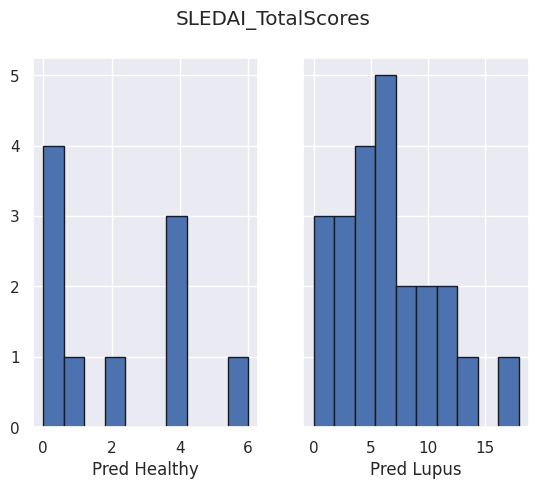

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.suptitle("SLEDAI_TotalScores")
ax1.hist(pred_healthy_sledai, bins=10, histtype="bar", ec="k")
ax2.hist(pred_lupus_sledai, bins=10, histtype="bar", ec="k")
ax1.set_xlabel("Pred Healthy")
ax2.set_xlabel("Pred Lupus")
plt.show()

In [42]:
# # TODO: Switch to using Pr(lupus), and analyze one fold at a time. See note above
# sns.scatterplot(
#     data=i_filtered_healthy_or_lupus,
#     hue="y_pred",
#     x="max_predicted_proba",
#     y="SLEDAI_TotalScore",
# )

In [43]:
# # check if paired test is better

In [44]:
stats.ttest_ind(
    i_filtered_healthy["SLEDAI_TotalScore"],
    i_filtered_lupus["SLEDAI_TotalScore"],
    nan_policy="omit",
    equal_var=False,
)

TtestResult(statistic=-3.502019849617389, pvalue=0.0014449852175160167, df=30.538317672904032)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Healthy/Background vs. Lupus: Mann-Whitney-Wilcoxon test smaller, P_val:4.242e-03 U_stat=4.800e+01


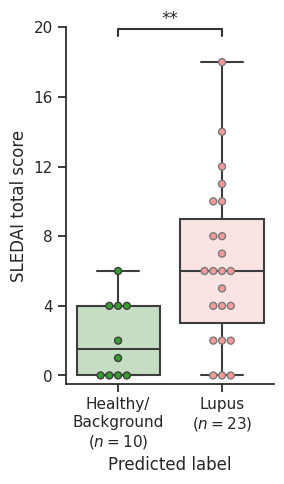

In [45]:
# One sided test for predicted-healthy having *lower* scores than predicted-lupus
with sns.axes_style("ticks"):
    x = "y_pred"
    y = "SLEDAI_TotalScore"
    order = [healthy_label, "Lupus"]
    fig, ax = plt.subplots(figsize=(3, 5))
    ax = sns.boxplot(
        data=i_filtered_healthy_or_lupus,
        x=x,
        y=y,
        order=order,
        # Disable outlier markers:
        fliersize=0,
        palette=sns.color_palette("Paired")[3:5],
    )

    # Force y-axis ticks to be integers since SLEDAIs are not floats. And reduce total number of ticks
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))

    for patch in ax.patches:
        # Set boxplot alpha transparency: https://github.com/mwaskom/seaborn/issues/979#issuecomment-1144615001
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, 0.3))
    sns.swarmplot(
        data=i_filtered_healthy_or_lupus,
        x=x,
        y=y,
        order=order,
        hue=x,
        legend=None,
        linewidth=1,
        edgecolor="gray",
        palette=sns.color_palette("Paired")[3:5],
        ax=ax,
    )

    # Annotate with statistical significance
    annot = Annotator(
        ax=ax,
        pairs=[order],
        data=i_filtered_healthy_or_lupus,
        x=x,
        y=y,
        order=order,
    )
    annot.configure(
        test="Mann-Whitney-ls", text_format="star", loc="outside", verbose=2
    )
    annot.apply_test(method="asymptotic")
    ax, test_results = annot.annotate()

    # Finish plot
    ax.set_xticklabels(
        genetools.plots.add_sample_size_to_labels(
            ax.get_xticklabels(), i_filtered_healthy_or_lupus, x
        )
    )
    genetools.plots.wrap_tick_labels(ax, wrap_amount=10)
    plt.ylim(
        -0.5,
    )
    plt.xlabel("Predicted label")
    plt.ylabel("SLEDAI total score")
    sns.despine(ax=ax)
    plt.tight_layout()
    genetools.plots.savefig(
        fig, f"{results_output_prefix}.lupus_sledai_vs_predictions.png", dpi=300
    )
    genetools.plots.savefig(
        fig, f"{results_output_prefix}.lupus_sledai_vs_predictions.pdf", dpi=600
    )
    if test_results is not None and len(test_results) > 0:
        with open(
            f"{results_output_prefix}.lupus_sledai_vs_predictions.test_results.txt",
            "w",
        ) as f:
            f.write(test_results[0].data.formatted_output)

In [46]:
# Test same with clinical-only score:

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Healthy/Background vs. Lupus: Mann-Whitney-Wilcoxon test smaller, P_val:6.424e-03 U_stat=5.150e+01


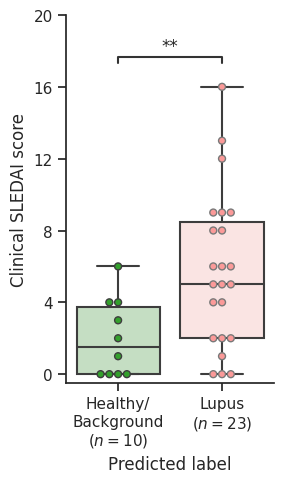

In [47]:
# One sided test for predicted-healthy having *lower* scores than predicted-lupus
with sns.axes_style("ticks"):
    x = "y_pred"
    y = "SLEDAI_ClinicalScore"
    order = [healthy_label, "Lupus"]
    fig, ax = plt.subplots(figsize=(3, 5))
    ax = sns.boxplot(
        data=i_filtered_healthy_or_lupus,
        x=x,
        y=y,
        order=order,
        # Disable outlier markers:
        fliersize=0,
        palette=sns.color_palette("Paired")[3:5],
    )

    # Force y-axis ticks to be integers since SLEDAIs are not floats. And reduce total number of ticks
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))

    for patch in ax.patches:
        # Set boxplot alpha transparency: https://github.com/mwaskom/seaborn/issues/979#issuecomment-1144615001
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, 0.3))
    sns.swarmplot(
        data=i_filtered_healthy_or_lupus,
        x=x,
        y=y,
        order=order,
        hue=x,
        legend=None,
        linewidth=1,
        edgecolor="gray",
        palette=sns.color_palette("Paired")[3:5],
        ax=ax,
    )

    # Annotate with statistical significance
    annot = Annotator(
        ax=ax,
        pairs=[order],
        data=i_filtered_healthy_or_lupus,
        x=x,
        y=y,
        order=order,
    )
    annot.configure(
        test="Mann-Whitney-ls", text_format="star", loc="outside", verbose=2
    )
    annot.apply_test(method="asymptotic")
    ax, test_results = annot.annotate()

    # Finish plot
    ax.set_xticklabels(
        genetools.plots.add_sample_size_to_labels(
            ax.get_xticklabels(), i_filtered_healthy_or_lupus, x
        )
    )
    genetools.plots.wrap_tick_labels(ax, wrap_amount=10)
    plt.ylim(
        -0.5,
    )
    plt.xlabel("Predicted label")
    plt.ylabel("Clinical SLEDAI score")
    sns.despine(ax=ax)
    plt.tight_layout()
    # genetools.plots.savefig(
    #     fig, f"{results_output_prefix}.lupus_sledai_vs_predictions.png", dpi=300
    # )
    # if test_results is not None and len(test_results) > 0:
    #     with open(
    #         f"{results_output_prefix}.lupus_sledai_vs_predictions.test_results.txt",
    #         "w",
    #     ) as f:
    #         f.write(test_results[0].data.formatted_output)